In [1]:
import json
graph_file = "data/graph_2layers_0seed.json"
data = json.load(open(graph_file, "r"))
local_correlators=data["paulis"]

In [2]:
from qopt_best_practices.qubit_selection import BackendEvaluator
from qopt_best_practices.utils import build_graph

In [3]:
# QAOA
G = build_graph(local_correlators)
N = len(G)
print(G)
print(local_correlators)

Graph with 10 nodes and 15 edges
[['IIIIIZZIII', 1.0], ['IIIIIIZIZI', 1.0], ['IIIIIIZIIZ', 1.0], ['ZIIIIZIIII', 1.0], ['IIIIZZIIII', 1.0], ['IIZIIIIZII', 1.0], ['IZZIIIIIII', 1.0], ['IIZZIIIIII', 1.0], ['IIIIIIIZZI', 1.0], ['IIIIZIIZII', 1.0], ['IIIIZIIIIZ', 1.0], ['IIIIIIIIZZ', 1.0], ['ZZIIIIIIII', 1.0], ['IZIZIIIIII', 1.0], ['ZIIZIIIIII', 1.0]]


In [4]:
from qiskit.providers.fake_provider import FakeWashington

backend = FakeWashington()
path_finder = BackendEvaluator(backend)
path, _ = path_finder.evaluate(N)
print(path)

[30, 31, 32, 36, 51, 50, 49, 48, 47, 35]


In [5]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy
from qiskit.transpiler import CouplingMap, Layout, PassManager

In [6]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(len(G.nodes))])

In [7]:
# 2. remap graph using SAT mapper for given strategy
from qopt_best_practices.sat_mapping import SATMapper

sm = SATMapper()
min_k, edge_map, paulis = sm.remap_graph_with_sat(graph=G, swap_strategy=swap_strategy)
print(paulis)
remapped_G = build_graph(paulis) # optimize
print(remapped_G)

[('IIIIIZZIII', 1.0), ('IIIIIIZIZI', 1.0), ('IIIIIIZIIZ', 1.0), ('ZIIIIZIIII', 1.0), ('IIIIZZIIII', 1.0), ('IIIIIIIZZI', 1.0), ('IIIIIIIIZZ', 1.0), ('IIIIZIIIIZ', 1.0), ('ZZIIIIIIII', 1.0), ('ZIIZIIIIII', 1.0), ('IIIIZIIZII', 1.0), ('IIZIIIIZII', 1.0), ('IZZIIIIIII', 1.0), ('IIZZIIIIII', 1.0), ('IZIZIIIIII', 1.0)]
Graph with 10 nodes and 15 edges


In [8]:
# 3. find best qubit subset to define the initial layout
path_finder = BackendEvaluator(backend)
# path, _ = path_finder.evaluate(len(remapped_G))
path, _ = path_finder.evaluate(len(remapped_G))
print(path)

[30, 31, 32, 36, 51, 50, 49, 48, 47, 35]


In [9]:
from qopt_best_practices.utils import create_qaoa_circ_pauli_evolution

theta = [1, 1, 0, 1]
qaoa_circ = create_qaoa_circ_pauli_evolution(N, paulis, theta, swap_strategy)
print(N, qaoa_circ)

10        ┌──────────────────┐┌───────┐┌──────────────────────────┐┌────────┐┌─┐»
  q_0: ┤0                 ├┤ Rx(0) ├┤0                         ├┤ Rx(-2) ├┤M├»
       │                  │├───────┤│                          │├────────┤└╥┘»
  q_1: ┤1                 ├┤ Rx(0) ├┤1                         ├┤ Rx(-2) ├─╫─»
       │                  │├───────┤│                          │├────────┤ ║ »
  q_2: ┤2                 ├┤ Rx(0) ├┤2                         ├┤ Rx(-2) ├─╫─»
       │                  │├───────┤│                          │├────────┤ ║ »
  q_3: ┤3                 ├┤ Rx(0) ├┤3                         ├┤ Rx(-2) ├─╫─»
       │                  │├───────┤│                          │├────────┤ ║ »
  q_4: ┤4                 ├┤ Rx(0) ├┤4                         ├┤ Rx(-2) ├─╫─»
       │  circuit-120-180 │├───────┤│  circuit-120-183_reverse │├────────┤ ║ »
  q_5: ┤5                 ├┤ Rx(0) ├┤5                         ├┤ Rx(-2) ├─╫─»
       │                  │├───────┤│            

In [10]:
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
)
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)

initial_layout = Layout.from_intlist(path, qaoa_circ.qregs[0]) # needs qaoa_circ

backend_cmap = CouplingMap(backend.configuration().coupling_map)
edge_coloring = {(idx, idx + 1): idx % 2 for idx in range(N)}

In [11]:
pm_pre = PassManager(
    [
        # FindCommutingPauliEvolutions(),
        # Commuting2qGateRouter(swap_strategy, edge_coloring),
        SetLayout(initial_layout),
        FullAncillaAllocation(backend_cmap),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# Insert swap gates, map to initial_layout and finally enlarge with ancilla.
tcirc = pm_pre.run(qaoa_circ)

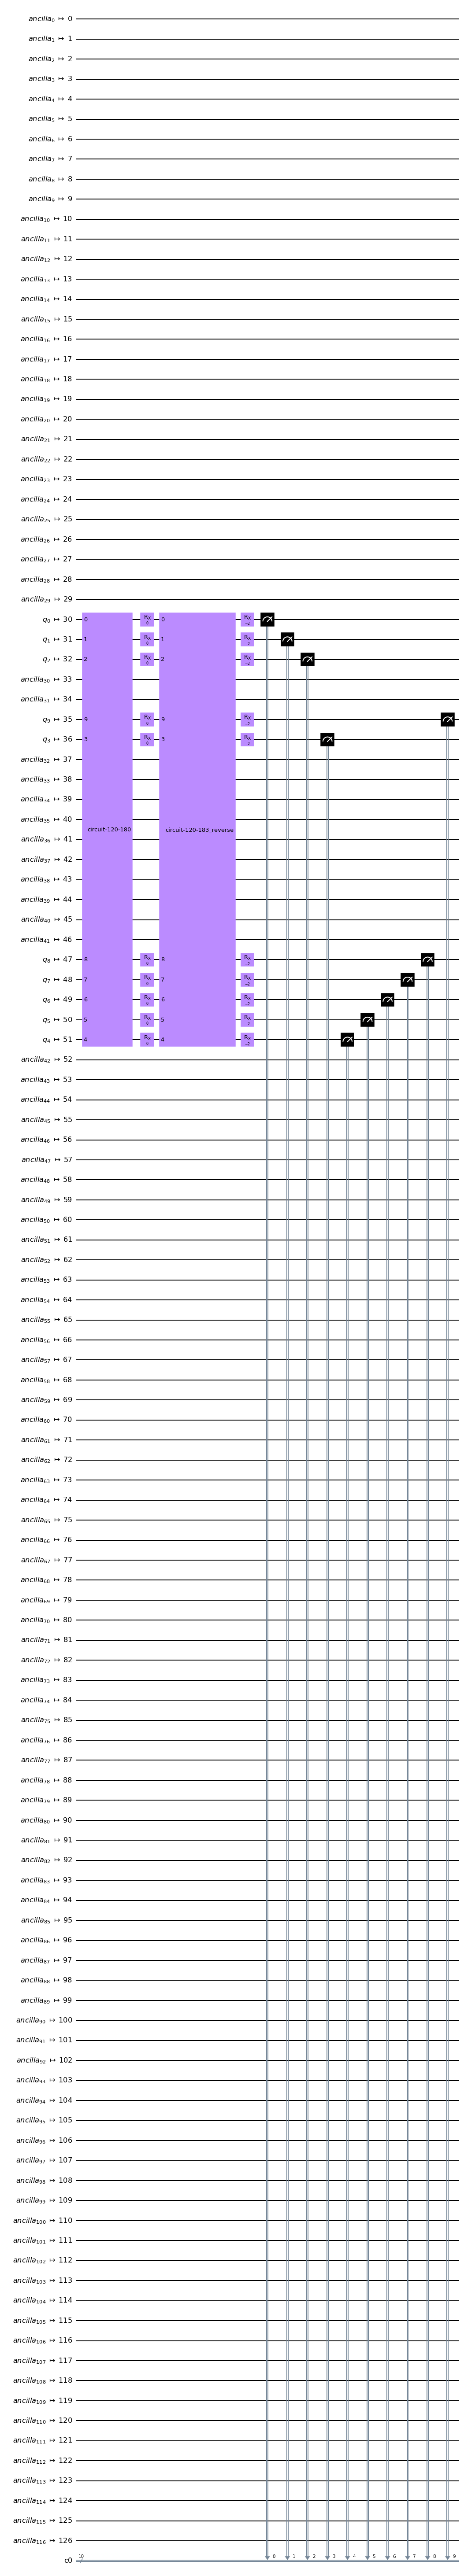

In [12]:
tcirc.draw('mpl')

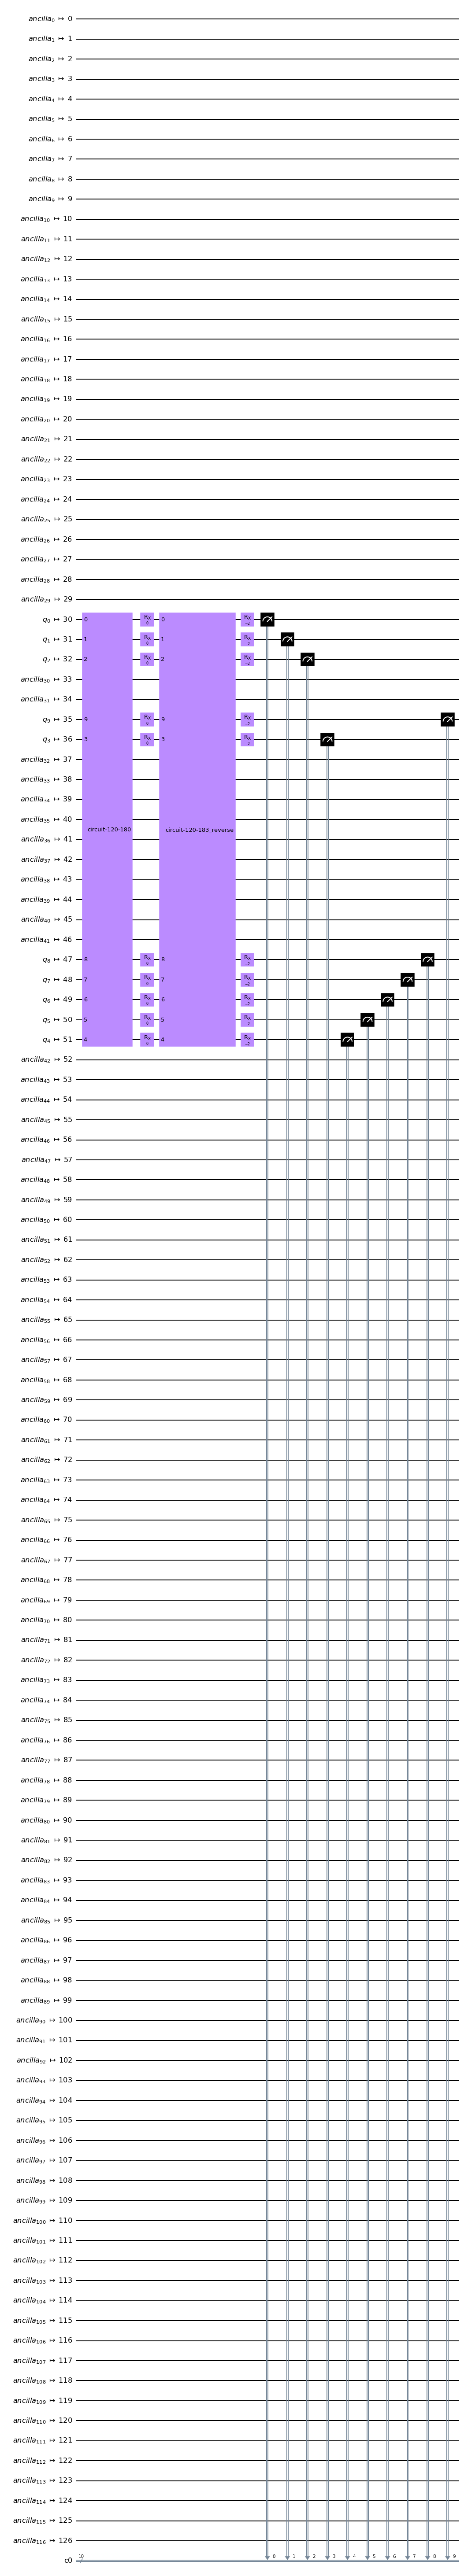

In [13]:
tcirc.draw('mpl')
